# Capstone Project - Lending Club loans data
Lending Club (LC) is a peer-to-peer online lending platform. It is the world’s largest marketplace connecting borrowers and investors, where consumers and small business owners lower the cost of their credit and enjoy a better experience than traditional bank lending, and investors earn attractive risk-adjusted returns.

**How it works:**
1. Customers interested in a loan complete a simple application at LendingClub.com
2. LC leverage online data and technology to quickly assess risk, determine a credit rating and assign appropriate interest rates.
3. Qualified applicants receive offers in just minutes and can evaluate loan options with no impact to their credit score
4. Investors ranging from individuals to institutions select loans in which to invest and can earn monthly returns

The entire process is online, using technology to lower the cost of credit and pass the savings back in the form of lower rates for borrowers and solid returns for investors. Here is the link to <a href = "https://www.lendingclub.com/public/how-peer-lending-works.actionmore">more</a> details about LC.

**Problem Statement:** <br>
In a peer-to-peer lending platform, it is normal that some borrowers will not fully pay for what they loan (Charged off - >120 days past due with their loan payment) even if LC provides lower interest rate compare to traditional bank loans. However, if the number of Charged off loans is increasing, it might negatively affect the investors Net Annualized Return (NAR) since the money funded by the investor will not be recovered anymore leading them to find other source of investments which in the long run, LC revenue will decrease if the number of their investors decreases.

**Questions:**
1. What are the characteristics or behaviors of borrowers that might be charging off their loans in the future?
2. What is the risk that a specific borrower will charge off their loan?
3. When these borrowers are going to charge off in the future?

## Part 1 - Importing Libraries and Datasets

I downloaded the dataset from the Lending Club site from year 2012-2014. It is composed of 432,810 rows and 142 columns overall.

In [1]:
#Install module
!pip install lifelines #for survival analysis

#Importing modules needed for the analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn.ensemble
import lime
import lime.lime_tabular
import shap
import time
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from scipy.stats import boxcox
from scipy import stats
from lifelines import *
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

%matplotlib inline

Invalid requirement: '#for'



In [2]:
df = pd.read_csv('lcdata.csv')
print(df.shape)
df.sample(5)

(423810, 143)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,months
346000,14000,14000,13950.0,60 months,22.15%,387.86,E,E5,Manager,10+ years,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,23.0
397892,24000,24000,24000.0,60 months,14.64%,566.44,C,C3,Public Relations,< 1 year,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,31.0
409438,15000,15000,15000.0,36 months,15.61%,524.48,C,C4,install tech,10+ years,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,17.0
201219,18000,18000,18000.0,60 months,14.31%,421.73,C,C4,VP OF OPERATIONS,4 years,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,4.0
218822,17000,17000,17000.0,36 months,8.19%,534.21,A,A5,Accounting Manager,1 year,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,27.0


# Data Preprocessing

Removing columns, creating new columns, binning ordinal values, and imputing missing values.

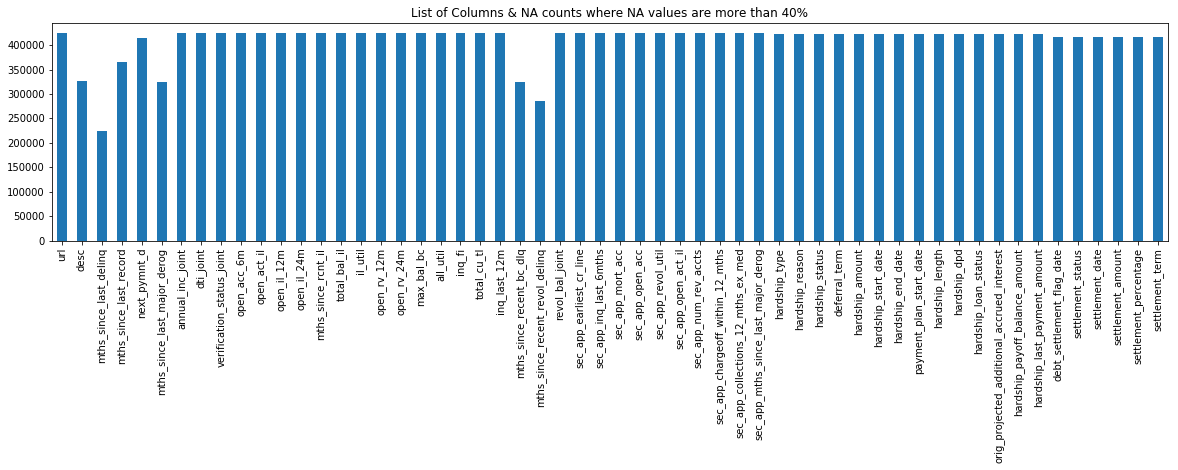

56

In [3]:
#Removing columns which have missing values greater than 40% of the data
NA_col = df.isnull().sum()
NA_col = NA_col[NA_col.values >(0.4*len(df))]

#Plotting the columns
plt.figure(figsize=(20,4))
NA_col.plot(kind='bar')
plt.title('List of Columns & NA counts where NA values are more than 40%')
plt.show()

#Number of columns that will be removed
NA_col.count()

In [4]:
#Function for removing columns which have greater than 40% missing values
def removeNulls(dataframe, axis =1, percent=0.4):
    '''
    * removeNull function will remove the rows and columns based on parameters provided.
    * dataframe : Name of the dataframe  
    * axis      : axis = 0 defines drop rows, axis =1(default) defines drop columns    
    * percent   : percent of data where column/rows values are null,default is 0.3(30%)
              
    '''
    df = dataframe.copy()
    ishape = df.shape
    if axis == 0:
        rownames = df.transpose().isnull().sum()
        rownames = list(rownames[rownames.values > percent*len(df)].index)
        df.drop(df.index[rownames],inplace=True) 
        print("\nNumber of Rows dropped\t: ",len(rownames))
    else:
        colnames = (df.isnull().sum()/len(df))
        colnames = list(colnames[colnames.values>=percent].index)
        df.drop(labels = colnames,axis =1,inplace=True)        
        print("Number of Columns dropped\t: ",len(colnames))
        
    print("\nOld dataset rows,columns",ishape,"\nNew dataset rows,columns",df.shape)

    return df

In [5]:
df = removeNulls(df, axis =1,percent = 0.4) #remove columns

Number of Columns dropped	:  56

Old dataset rows,columns (423810, 143) 
New dataset rows,columns (423810, 87)


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,423810.0,14641.033659,8300.162717,1.000000e+03,8000.000000,12800.00000,20000.00000,3.500000e+04
funded_amnt,423810.0,14639.914938,8299.264937,1.000000e+03,8000.000000,12800.00000,20000.00000,3.500000e+04
funded_amnt_inv,423810.0,14631.905082,8295.368633,9.500000e+02,8000.000000,12800.00000,20000.00000,3.500000e+04
installment,423810.0,443.022421,243.982683,4.930000e+00,267.600000,390.74000,578.68000,1.409990e+03
annual_inc,423810.0,73690.425184,53941.858610,3.000000e+03,45000.000000,63500.00000,90000.00000,7.500000e+06
dti,423810.0,17.605362,7.852101,0.000000e+00,11.710000,17.23000,23.23000,3.999000e+01
delinq_2yrs,423810.0,0.297940,0.819312,0.000000e+00,0.000000,0.00000,0.00000,2.900000e+01
inq_last_6mths,423810.0,0.777037,1.033789,0.000000e+00,0.000000,0.00000,1.00000,8.000000e+00
open_acc,423810.0,11.371803,4.996683,0.000000e+00,8.000000,11.00000,14.00000,8.400000e+01
pub_rec,423810.0,0.170843,0.529098,0.000000e+00,0.000000,0.00000,0.00000,6.300000e+01


The mean loan amount funded by the investors was around 14,700 USD and it deviates by 8300.16 which implies that the range of loans amount is widely distributed. Moreover, we can see that the Debt-to-Income (DTI) ratio of borrowers is relatively high that's why some borrowers have high interest rate which can be seen as a possible factor why they charge off their loans.

In [7]:
#Remove columns with 1 unique value
unique = df.nunique()
unique = unique[unique.values == 1]
df.drop(labels = list(unique.index), axis =1, inplace=True)
print("So now we are left with",df.shape ,"rows & columns.")


So now we are left with (423810, 85) rows & columns.


In [8]:
print(df.emp_length.unique()) #We observed that 1 year has two unique counts so we replace them
df.emp_length.fillna('0',inplace=True)
#df.emp_length.replace(' 1 year', '1 year', inplace = True)
df.emp_length.replace('0','< 1 year', inplace = True)
df.emp_length.replace('< 1 year','0-3 years', inplace = True)
df.emp_length.replace('1 year','0-3 years', inplace = True)
df.emp_length.replace('2 years','0-3 years', inplace = True)
df.emp_length.replace('3 years','0-3 years', inplace = True)
df.emp_length.replace('4 years','4-7 years', inplace = True)
df.emp_length.replace('5 years','4-7 years', inplace = True)
df.emp_length.replace('6 years','4-7 years', inplace = True)
df.emp_length.replace('7 years','4-7 years', inplace = True)
df.emp_length.replace('8 years','8-10 years', inplace = True)
df.emp_length.replace('9 years','8-10 years', inplace = True)
df.emp_length.replace('10+ years','8-10 years', inplace = True)
df.emp_length.value_counts()


['3 years' '10+ years' '5 years' '6 years' '4 years' '1 year' '2 years'
 '7 years' '9 years' '8 years' '< 1 year' nan]


8-10 years    178059
0-3 years     146006
4-7 years      99745
Name: emp_length, dtype: int64

In [9]:
df.to_csv('lcdata2.csv')

In [10]:
df2 = pd.read_csv('lcdata2.csv')
df2.columns

Index(['Unnamed: 0', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl

In [11]:
print(df2.shape)

(423810, 86)


After removing the columns which have a great number of missing values, we are now down to 400,000 plus rows and 85 columns. We will now change the values for each columns, try to bin some columns and removing irrelevant columns

**How I decide to remove the irrelevant columns**
1. Leaks info from the future (after the loan has being funded)
2. Doesn't affect borrower's ability to pay for the loan
3. Contains redundant info

We want to be careful about these criteria since it might affect our analysis in the long run. We need to be sure that the data we will use for training is at the point of loan application only.

In [13]:
cols = ['Unnamed: 0','funded_amnt', 'funded_amnt_inv','sub_grade', 'emp_title','zip_code','out_prncp','out_prncp_inv','total_pymnt', 'total_pymnt_inv','total_rec_prncp','total_rec_int',
'total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_amnt','collections_12_mths_ex_med','tot_cur_bal','bc_open_to_buy',
'mo_sin_old_il_acct','mo_sin_old_rev_tl_op','mo_sin_rcnt_tl','mths_since_recent_bc','mths_since_recent_inq','num_actv_bc_tl','num_bc_tl',
'num_il_tl','num_rev_accts','num_actv_rev_tl','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m','tot_hi_cred_lim','total_bc_limit',
'total_il_high_credit_limit','earliest_cr_line','last_pymnt_d','title','initial_list_status']

df2 = df2.drop(cols, axis =1)
print(df2.shape)


(423810, 46)


In [14]:
cols = ['last_credit_pull_d','tot_coll_amt','total_rev_hi_lim','acc_open_past_24mths','mo_sin_rcnt_rev_tl_op','acc_now_delinq','num_op_rev_tl','num_rev_tl_bal_gt_0','revol_util']

df2 = df2.drop(cols, axis = 1)
print(df2.shape)

(423810, 37)


Text(0, 0.5, 'Data type')

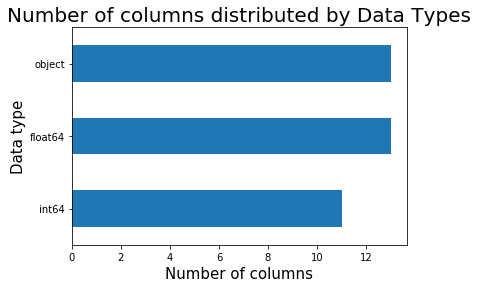

In [15]:
#Let look at the distribution of my dataset based on data types so I can group the numerical and categorical variables
df2.dtypes.value_counts().sort_values().plot(kind='barh')
plt.title('Number of columns distributed by Data Types',fontsize=20)
plt.xlabel('Number of columns',fontsize=15)
plt.ylabel('Data type',fontsize=15)

In [16]:
df2.to_csv('lcdata3.csv')

In [17]:
df3 = pd.read_csv('lcdata3.csv')
df3.issue_d.unique()
df3.shape
#df3.issue_d.replace('41974','14-Dec', inplace = True)


(423810, 38)

In [18]:
#Create a column for month and year
df3['issue_year'],df3['issue_month'] = df3['issue_d'].str.split('-', 1).str
df3[['issue_d','issue_month','issue_year']].head()

,issue_d,issue_month,issue_year
0,13-Dec,Dec,13
1,13-Dec,Dec,13
2,13-Dec,Dec,13
3,13-Dec,Dec,13
4,13-Dec,Dec,13


In [19]:
#We need to change the order of months 
months_order = ["Jan", "Feb", "Mar", "Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
df3['issue_month'] = pd.Categorical(df3['issue_month'],categories=months_order, ordered=True)

In [20]:
df3 = df3.drop('Unnamed: 0', axis= 1)
df3.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,hardship_flag,debt_settlement_flag,months,issue_year,issue_month
0,12000,36 months,7.62%,373.94,A,0-3 years,MORTGAGE,96500.0,Not Verified,13-Dec,...,100.0,100.0,0,0,46738.0,N,N,30.0,13,Dec
1,27050,36 months,10.99%,885.46,B,8-10 years,OWN,55000.0,Verified,13-Dec,...,100.0,25.0,0,0,70186.0,N,N,31.0,13,Dec
2,12000,36 months,11.99%,398.52,B,8-10 years,MORTGAGE,130000.0,Source Verified,13-Dec,...,100.0,1.0,0,0,44327.0,N,N,38.0,13,Dec
3,28000,36 months,7.62%,872.52,A,4-7 years,MORTGAGE,325000.0,Source Verified,13-Dec,...,100.0,16.7,0,0,199739.0,N,N,8.0,13,Dec
4,27600,60 months,19.97%,730.78,D,4-7 years,MORTGAGE,73000.0,Source Verified,13-Dec,...,87.5,80.0,0,0,37808.0,N,N,41.0,13,Dec


In [21]:
#Finds column with which unique values tend to occur less than 10 times
for col in df3.columns:
    if (len(df3[col].unique()) < 4):
        print(df3[col].value_counts())
        print()

 36 months    306462
 60 months    117348
Name: term, dtype: int64

8-10 years    178059
0-3 years     146006
4-7 years      99745
Name: emp_length, dtype: int64

Verified           154618
Source Verified    141851
Not Verified       127341
Name: verification_status, dtype: int64

n    423806
y         4
Name: pymnt_plan, dtype: int64

N    423804
Y         6
Name: hardship_flag, dtype: int64

N    417438
Y      6372
Name: debt_settlement_flag, dtype: int64

14    235629
13    134814
12     53367
Name: issue_year, dtype: int64



Since the value with 'y' in payment plan and hardship flag tend to occur less than 10 times. We can drop this column since it will not much affect our dependent variable.

In [22]:
df3 = df3.drop(['pymnt_plan','hardship_flag'], axis = 1)
print(df3.shape)
df3.to_csv('lcdata4.csv')

(423810, 37)


In [23]:
df3['loan_status'].value_counts()
df3['int_rate'] = df3['int_rate'].str.rstrip('%').astype('float') / 100.0 #removed the percentage sign on interest rate column

We will now adjust our target variable which is the loan status. We will remove Current, Late, and In Grace Period loans and we will code Fully Paid as 0 otherwise 1.

In [24]:
df3 = df3[df3.loan_status != 'Current']
df3 = df3[df3.loan_status != 'In Grace Period']
df3 = df3[df3.loan_status != 'Late (16-30 days)']
df3 = df3[df3.loan_status != 'Late (31-120 days)']
df3.loan_status.value_counts()
df3['loan_status'] = df3['loan_status'].replace({'Charged Off':'Default'})
df3['loan_status'].value_counts()

Fully Paid    343216
Default        71028
Name: loan_status, dtype: int64

In [25]:
#Decreasing the number of categoriess on the purpose variable
#df3.purpose.replace('NONE','OTHER',inplace = True)
#df3.purpose.replace('ANY','OTHER',inplace = True)
#df3.purpose.value_counts()
df3.purpose.replace('house','home_improvement',inplace = True)
df3.purpose.replace('small_business','major_purchase',inplace = True)
df3.purpose.replace('car','major_purchase',inplace = True)
df3.purpose.replace('medical','major_purchase',inplace = True)
df3.purpose.replace('moving','Other',inplace = True)
df3.purpose.replace('vacation','Other',inplace = True)
df3.purpose.replace('wedding','Other',inplace = True)
df3.purpose.replace('renewable_energy','Other',inplace = True)
df3.purpose.replace('other','Other',inplace = True)
df3.purpose.value_counts()

debt_consolidation    248364
credit_card            96423
Other                  24967
home_improvement       24620
major_purchase         19870
Name: purpose, dtype: int64

# Exploratory Data Analysis

Text(0, 0.5, 'Average loan amount issued')

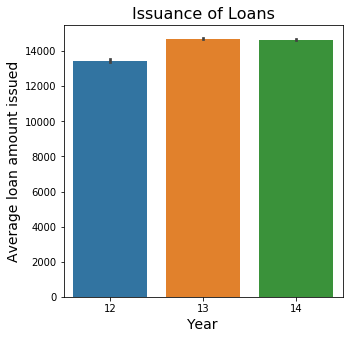

In [26]:
plt.figure(figsize=(5,5))
sns.barplot('issue_year', 'loan_amnt', data=df3, palette='tab10')
plt.title('Issuance of Loans', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average loan amount issued', fontsize=14)

## Assessment: 
Issuance of loan increases per year

[Text(0, 0.5, '(%)')]

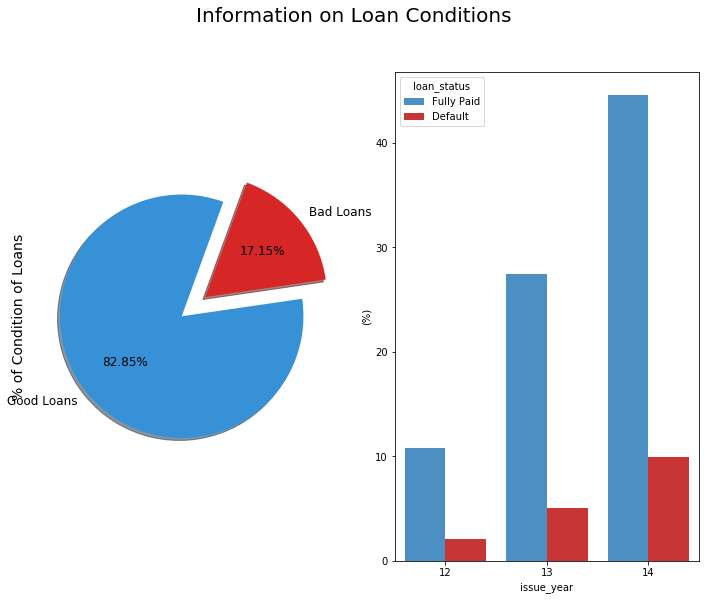

In [27]:
f, ax = plt.subplots(1,2, figsize=(12,9))

colors = ["#3791D7", "#D72626"]
labels ="Good Loans", "Bad Loans"

plt.suptitle('Information on Loan Conditions', fontsize=20)

df3['loan_status'].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=70)


# ax[0].set_title('State of Loan', fontsize=16)
ax[0].set_ylabel('% of Condition of Loans', fontsize=14)

# sns.countplot('loan_condition', data=df, ax=ax[1], palette=colors)
# ax[1].set_title('Condition of Loans', fontsize=20)
# ax[1].set_xticklabels(['Good', 'Bad'], rotation='horizontal')
palette = ["#3791D7", "#E01E1B"]

sns.barplot(x="issue_year", y="loan_amnt", hue="loan_status", data=df3, palette=palette, estimator=lambda x: len(x) / len(df3) * 100)
ax[1].set(ylabel="(%)")

## Assessment
The number of Default increases per year which can be a risk for investors to invest their money on peer to peer lending.

Lending Club (LC) revenue will decrease if the number of their investors will decrease through time because of the increase of default borrowers. LC club needs to take action to maintain their investors.

Text(0.5, 1.0, 'Type of Loans by Grade')

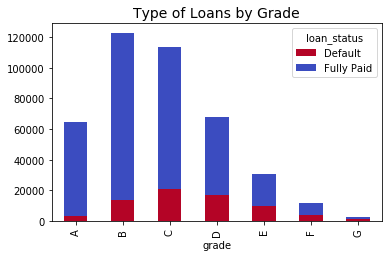

In [29]:
fig = plt.figure(figsize=(13,8))

ax1 = fig.add_subplot(221)
#ax2 = fig.add_subplot(222)

cmap = plt.cm.coolwarm_r

loans_by_region = df3.groupby(['grade', 'loan_status']).size()
loans_by_region.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax1, grid=False)
ax1.set_title('Type of Loans by Grade', fontsize=14)

#by_interest = df.groupby(['issue_year', 'loan_status']).int_rate.mean()
#by_interest.unstack().plot(ax=ax2, colormap=cmap)
#ax2.set_title('Average Interest rate by Loan Condition', fontsize=14)
#ax2.set_ylabel('Interest Rate (%)', fontsize=12)

# Assessment: 

Good loans tend to centralize on B grade borrowers while Bad loans tend to centralize on C grade borrowers. Generally, we can't say that the lower borrower grade will be, the higher the chance to default.

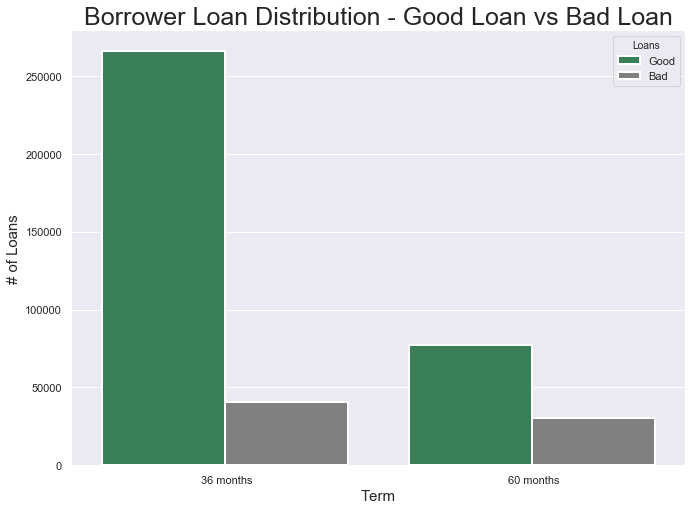

In [30]:
pal = {'Fully Paid':"seagreen", 'Default':"gray"}
sns.set(style="darkgrid")
plt.subplots(figsize = (11,8))
ax = sns.countplot(x = "term", 
                   hue="loan_status",
                   data = df3, 
                   linewidth=2, 
                   palette = pal
)

## Fixing title, xlabel and ylabel
plt.title("Borrower Loan Distribution - Good Loan vs Bad Loan", fontsize = 25)
plt.xlabel("Term", fontsize = 15);
plt.ylabel("# of Loans", fontsize = 15)

## Fixing xticks
#labels = ['Female', 'Male']
#plt.xticks(sorted(train.Sex.unique()), labels)

## Fixing legends
leg = ax.get_legend()
leg.set_title("Loans")
legs = leg.texts
legs[0].set_text("Good")
legs[1].set_text("Bad")
plt.show()

# Assessment:

Borrower's term plan is not significant for determining whether a specific borrower will default.

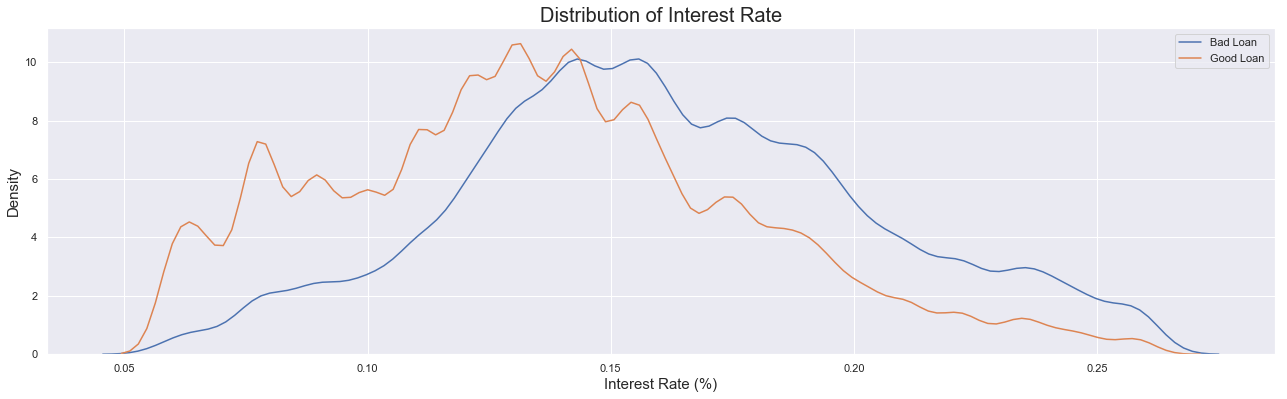

In [31]:
fig = plt.figure(figsize=(22,6))
sns.kdeplot(df3.loc[df3['loan_status'] == 'Default', 'int_rate'], label = 'Bad Loan')
sns.kdeplot(df3.loc[df3['loan_status'] == 'Fully Paid', 'int_rate'], label = 'Good Loan');
plt.xlabel('Interest Rate (%)',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.title('Distribution of Interest Rate',fontsize=20);

# Assessment: 

The mean interest rate for Good and Bad loan doesn't have much difference. Thus interest rate is not a significant factor for determining a Bad loan.

In [32]:
df3['addr_state'].unique()

# Make a list with each of the regions by state.

west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

df3['region'] = np.nan

def find_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
    
df3['region'] = df3['addr_state'].apply(find_regions)

In [33]:
def crosstab(df,col):
    '''
    df : Dataframe
    col: Column Name
    '''
    crosstab = pd.crosstab(df[col], df['loan_status'],margins=True)
    crosstab['Probability_Default'] = round((crosstab['Default']/crosstab['All']),3)
    crosstab = crosstab[0:-1]
    return crosstab

def graph_combo(df,col,stacked= True):
    '''
    df      : Dataframe
    col     : Column Name
    stacked : True(default) for Stacked Bar
    '''
    # get dataframe from crosstab function
    plotCrosstab = crosstab(df,col)
    
    linePlot = plotCrosstab[['Probability_Default']]      
    barPlot =  plotCrosstab.iloc[:,0:2]
    ax = linePlot.plot(figsize=(20,8), marker='o',color = 'g')
    ax2 = barPlot.plot(kind='bar',ax = ax,rot=1,secondary_y=True,stacked=stacked)
    ax.set_title(df[col].name.title()+' vs Probability Default',fontsize=20,weight="bold")
    ax.set_xlabel(df[col].name.title(),fontsize=14)
    ax.set_ylabel('Probability of Default',color = 'r',fontsize=14)
    ax2.set_ylabel('Number of Applicants',color = 'y',fontsize=14)
    plt.show()

loan_status,Default,Fully Paid,All,Probability_Default
purpose,,,,
Other,4668,20299,24967,0.187
credit_card,13862,82561,96423,0.144
debt_consolidation,45058,203306,248364,0.181
home_improvement,3851,20769,24620,0.156
major_purchase,3589,16281,19870,0.181


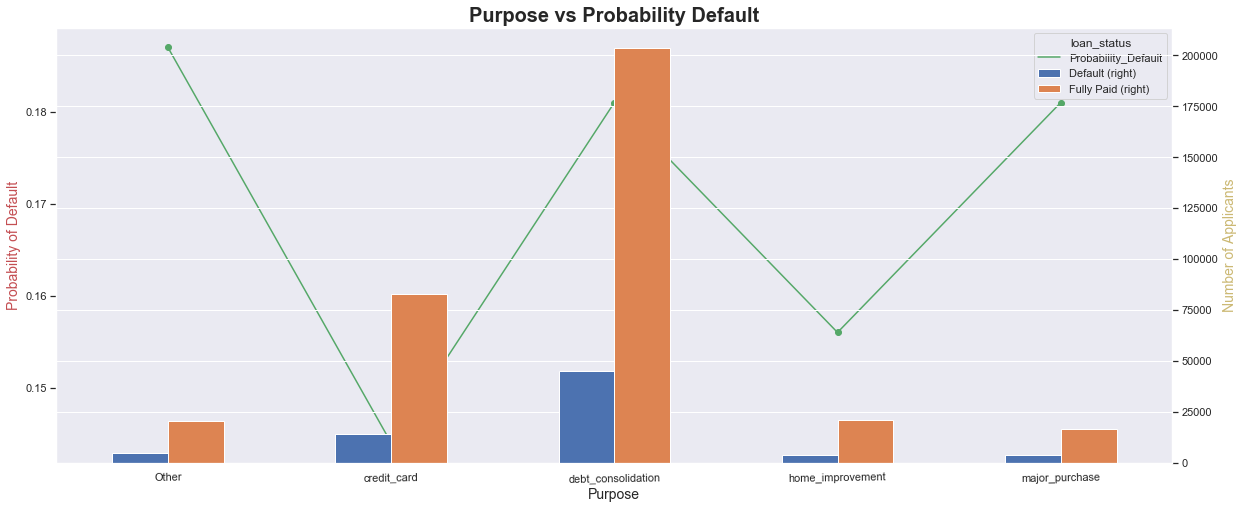

In [35]:
purpose = crosstab(df3,'purpose')
display(purpose)

graph_combo(df =df3,col ='purpose',stacked=False)

# Assessment:



loan_status,Default,Fully Paid,All,Probability_Default
grade,,,,
A,3567,60909,64476,0.055
B,13714,109166,122880,0.112
C,21119,92419,113538,0.186
D,17127,51039,68166,0.251
E,10097,20850,30947,0.326
F,4254,7294,11548,0.368
G,1150,1539,2689,0.428


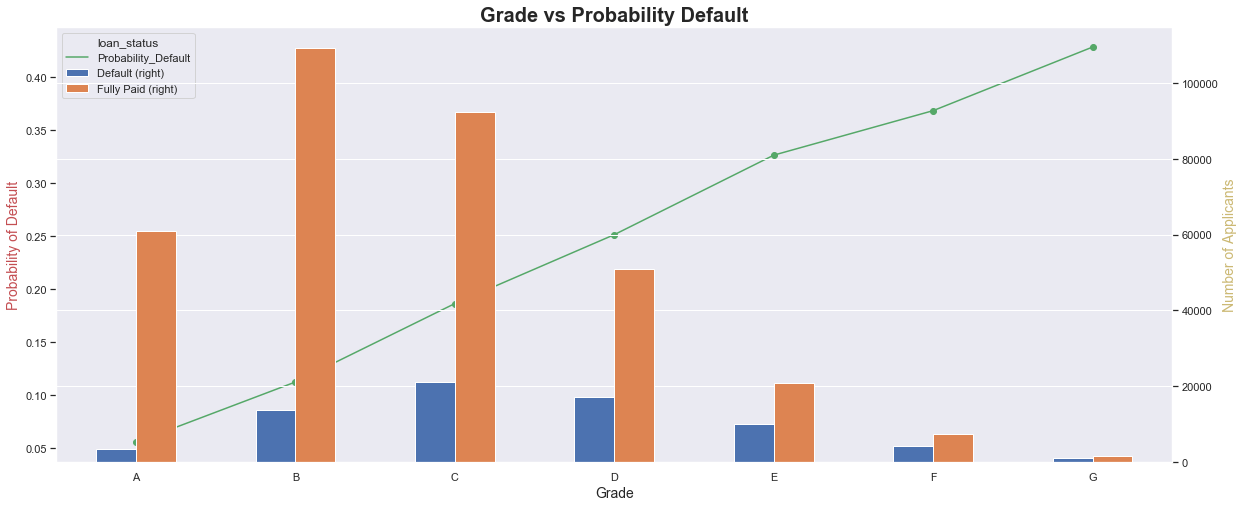

In [36]:
grade = crosstab(df3,'grade')
display(grade)

graph_combo(df =df3,col ='grade',stacked=False)

# Assessment:

In terms of the borrower's probability to default, the lower the grade of the borrower. However, it can be seen that there are more loans  defaulted on borrowers having a grade of C-D. Maybe these borrowers are just making their credit scores good to have a lower interest rate but they have a habit of not fully paying the money that they loan.

loan_status,Default,Fully Paid,All,Probability_Default
emp_length,,,,
0-3 years,25301,117821,143122,0.177
4-7 years,16679,81160,97839,0.170
8-10 years,29048,144235,173283,0.168


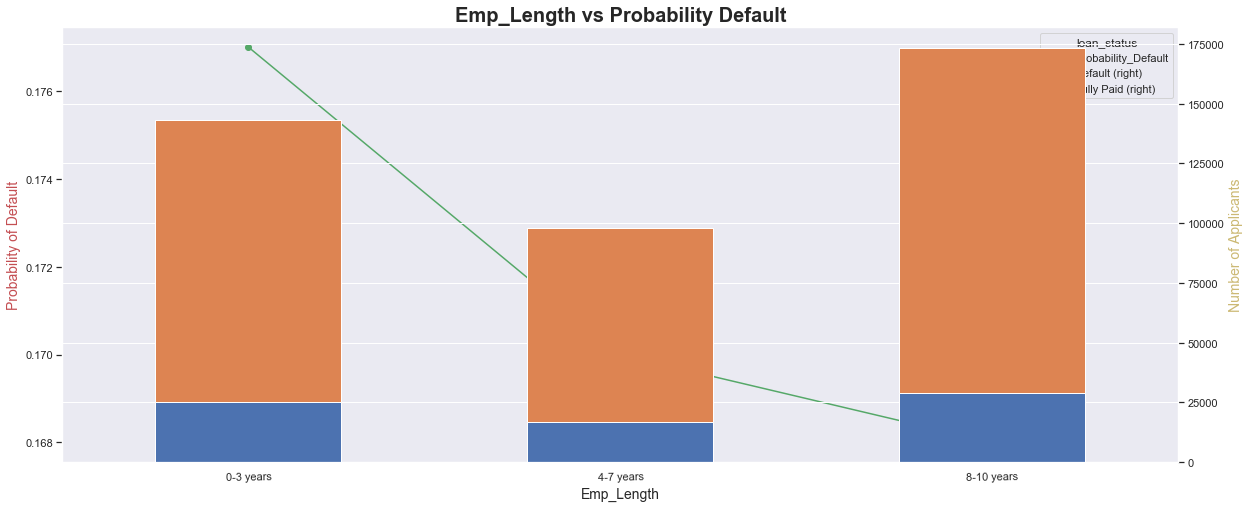

In [37]:
emp_length = crosstab(df3,'emp_length')
display(emp_length)

graph_combo(df = df3,col ='emp_length')

# Assessment:
We can observe that in terms of proportion of bad loans, if the borrower is working for less than a year to 3 years of work, they have a high chance of defaulting their loan.

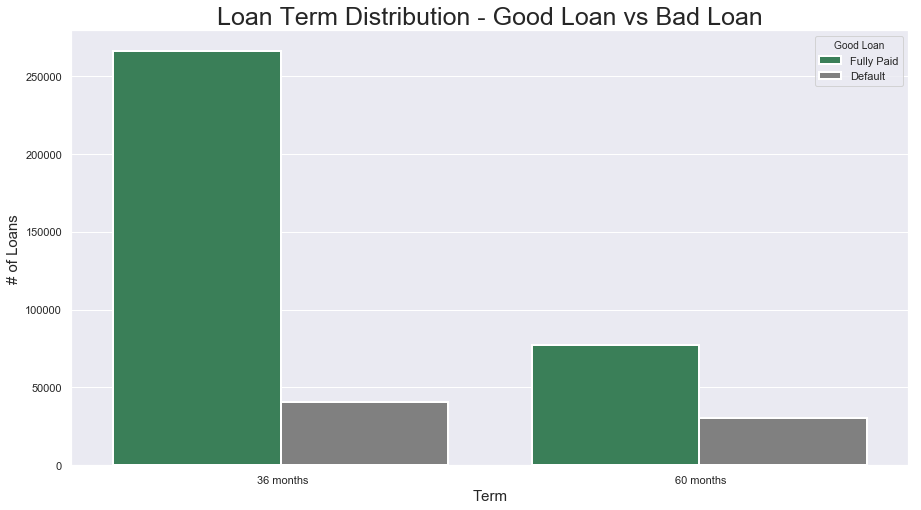

In [38]:
pal = {'Fully Paid':"seagreen", 'Default':"gray"}
sns.set(style="darkgrid")
plt.subplots(figsize = (15,8))
ax = sns.countplot(x = "term", 
                   hue="loan_status",
                   data = df3, 
                   linewidth=2, 
                   palette = pal
)

## Fixing title, xlabel and ylabel
plt.title("Loan Term Distribution - Good Loan vs Bad Loan", fontsize = 25)
plt.xlabel("Term", fontsize = 15);
plt.ylabel("# of Loans", fontsize = 15)

## Fixing xticks
#labels = ['Female', 'Male']
#plt.xticks(sorted(train.Sex.unique()), labels)

## Fixing legends
leg = ax.get_legend()
leg.set_title("Good Loan")
legs = leg.texts
legs[0].set_text("Fully Paid")
legs[1].set_text("Default")
plt.show()

We can observe that the number of default loans are almost the same per kind of term payments.

Text(0, 0.5, 'Data type')

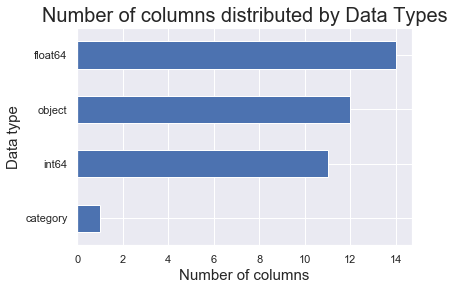

In [39]:
df3.dtypes.value_counts().sort_values().plot(kind='barh')
plt.title('Number of columns distributed by Data Types',fontsize=20)
plt.xlabel('Number of columns',fontsize=15)
plt.ylabel('Data type',fontsize=15)

# Final  Data Preprocessing

Separated numerical and categorical features. Imputed all missing values.Implemented OneHot Encoding for categorical features.

In [40]:
numbers = df3.select_dtypes(include=['float64','int64']).copy()
objcts = df3.select_dtypes(include = 'object').copy()

In [41]:
numbers.isna().sum()

loan_amnt                       0
int_rate                        0
installment                     0
annual_inc                      0
dti                             0
delinq_2yrs                     0
inq_last_6mths                  0
open_acc                        0
pub_rec                         0
revol_bal                       0
total_acc                       0
avg_cur_bal                 27753
bc_util                     11621
chargeoff_within_12_mths        0
delinq_amnt                     0
mort_acc                     7495
num_accts_ever_120_pd       27741
num_bc_sats                 16055
num_sats                    16055
pct_tl_nvr_dlq              27894
percent_bc_gt_75            11493
pub_rec_bankruptcies            0
tax_liens                       0
total_bal_ex_mort            7495
months                        293
dtype: int64

In [42]:
numbers.describe().T#we describe the numbers dataframe to know what kind of strategy we will use to impute missing values
#We decided to use the median value to impute for the missing values

,count,mean,std,min,25%,50%,75%,max
loan_amnt,414244.0,14515.856355,8277.673972,1000.00,8000.0000,12500.0000,20000.0000,3.500000e+04
int_rate,414244.0,0.139596,0.043893,0.06,0.1099,0.1368,0.1678,2.606000e-01
installment,414244.0,442.071398,245.083377,4.93,265.6800,388.1400,578.2800,1.409990e+03
annual_inc,414244.0,73538.627097,53597.766091,3000.00,45000.0000,63000.0000,89033.0000,7.500000e+06
dti,414244.0,17.547675,7.836204,0.00,11.6700,17.1800,23.1600,3.999000e+01
delinq_2yrs,414244.0,0.296031,0.816788,0.00,0.0000,0.0000,0.0000,2.900000e+01
inq_last_6mths,414244.0,0.781916,1.036362,0.00,0.0000,0.0000,1.0000,8.000000e+00
open_acc,414244.0,11.350354,4.986146,0.00,8.0000,11.0000,14.0000,8.400000e+01
pub_rec,414244.0,0.171054,0.529090,0.00,0.0000,0.0000,0.0000,6.300000e+01
revol_bal,414244.0,16295.121257,20349.604546,0.00,6633.0000,11933.0000,20425.2500,2.568995e+06


In [43]:
from scipy import stats
cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'total_acc', 'avg_cur_bal', 'bc_util', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mort_acc', 'num_accts_ever_120_pd', 'num_bc_sats',
       'num_sats', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
       'pub_rec_bankruptcies', 'tax_liens', 'total_bal_ex_mort','months']
for col in cols:
    print(col ,stats.shapiro(numbers[col]))

loan_amnt (0.9445400834083557, 0.0)
int_rate (0.9839239716529846, 0.0)
installment (0.9415225982666016, 0.0)
annual_inc (0.5713726878166199, 0.0)
dti (0.9908382892608643, 0.0)
delinq_2yrs (0.4054153561592102, 0.0)
inq_last_6mths (0.7484458684921265, 0.0)
open_acc (0.9344494938850403, 0.0)
pub_rec (0.3362157344818115, 0.0)
revol_bal (0.4795900583267212, 0.0)
total_acc (0.9619814157485962, 0.0)
avg_cur_bal (nan, 1.0)
bc_util (nan, 1.0)
chargeoff_within_12_mths (0.05297893285751343, 0.0)
delinq_amnt (0.003963887691497803, 0.0)
mort_acc (nan, 1.0)
num_accts_ever_120_pd (nan, 1.0)
num_bc_sats (nan, 1.0)
num_sats (nan, 1.0)
pct_tl_nvr_dlq (nan, 1.0)
percent_bc_gt_75 (nan, 1.0)
pub_rec_bankruptcies (0.3526045083999634, 0.0)
tax_liens (0.07871139049530029, 0.0)
total_bal_ex_mort (nan, 1.0)
months (nan, 1.0)


# Assessment:

All numerical variables does not follow normal distribution that is why we will use their MEDIAN to impute those missing values.

In [44]:
### Impute mean values for all the columns selected
cols = ['avg_cur_bal', 'bc_util','mort_acc','num_accts_ever_120_pd','num_bc_sats','num_sats','pct_tl_nvr_dlq','percent_bc_gt_75','total_bal_ex_mort','months']

imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'median')
numbers[cols] = imp_mean.fit_transform(numbers[cols])
numbers.isna().sum()
#numbers.columns


loan_amnt                   0
int_rate                    0
installment                 0
annual_inc                  0
dti                         0
delinq_2yrs                 0
inq_last_6mths              0
open_acc                    0
pub_rec                     0
revol_bal                   0
total_acc                   0
avg_cur_bal                 0
bc_util                     0
chargeoff_within_12_mths    0
delinq_amnt                 0
mort_acc                    0
num_accts_ever_120_pd       0
num_bc_sats                 0
num_sats                    0
pct_tl_nvr_dlq              0
percent_bc_gt_75            0
pub_rec_bankruptcies        0
tax_liens                   0
total_bal_ex_mort           0
months                      0
dtype: int64

In [45]:
numbers.to_csv('surv1.csv')
numbers.shape

(414244, 25)

In [43]:
#Standard Scaler
#cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
#       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
#       'total_acc', 'avg_cur_bal', 'bc_util', 'chargeoff_within_12_mths',
#       'delinq_amnt', 'mort_acc', 'num_accts_ever_120_pd', 'num_bc_sats',
#       'num_sats', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
#       'pub_rec_bankruptcies', 'tax_liens', 'total_bal_ex_mort','months']
#scaler = StandardScaler()
#scaled_data = pd.DataFrame(data = scaler.fit_transform(numbers),columns = cols)
#scaled_data.head()

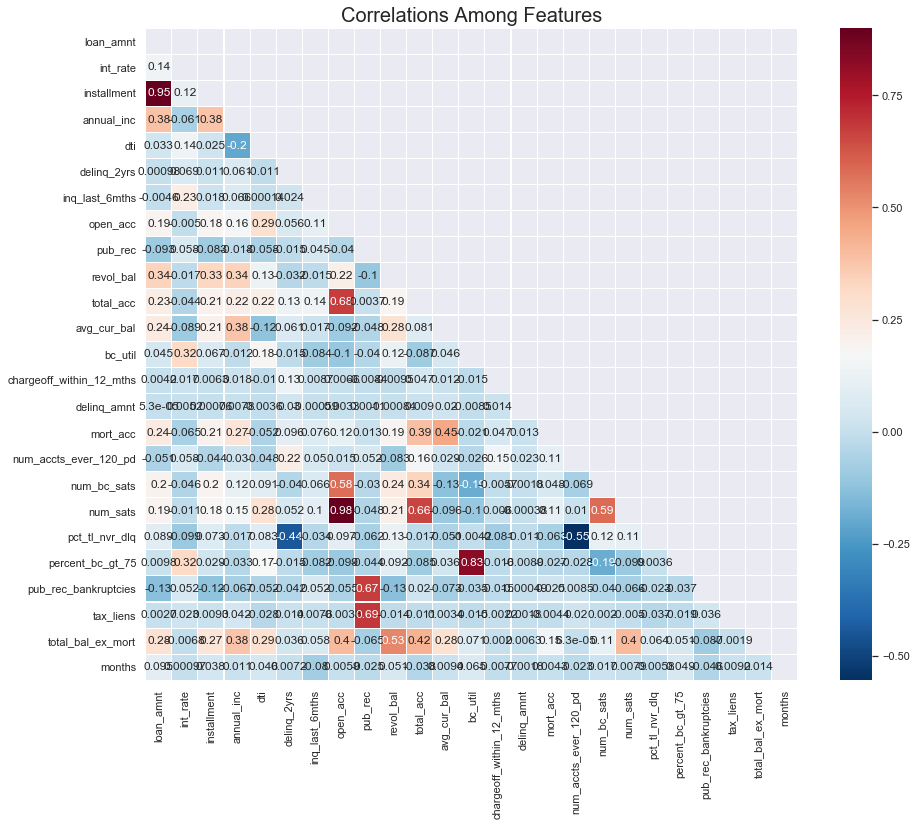

In [46]:
mask = np.zeros_like(numbers.corr())
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize = (15,12))
sns.heatmap(numbers.corr(), 
            annot=True,
            mask = mask,
            cmap = 'RdBu_r',
            linewidths=0.1, 
            linecolor='white',
            vmax = .9,
            square=True)
plt.title("Correlations Among Features", y = 1.03,fontsize = 20);

# Assessment:

We can see that there still exists a strong correlations (Correlation which is between 0.60-0.80) between some variables. We need to remove this predictors to avoid multicollinearity in our final dataset that we will be using for classification.

In [47]:
cols = ['installment','pub_rec','percent_bc_gt_75','num_sats','open_acc']
numbers  = numbers.drop(cols, axis = 1)
numbers.columns

Index(['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'revol_bal', 'total_acc', 'avg_cur_bal', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mort_acc',
       'num_accts_ever_120_pd', 'num_bc_sats', 'pct_tl_nvr_dlq',
       'pub_rec_bankruptcies', 'tax_liens', 'total_bal_ex_mort', 'months'],
      dtype='object')

In [48]:
numbers.to_csv('surv1.csv')

In [49]:
objcts.isna().sum() # No missing values for my categorical feature

term                    0
grade                   0
emp_length              0
home_ownership          0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
addr_state              0
debt_settlement_flag    0
issue_year              0
region                  0
dtype: int64

In [50]:
objcts.home_ownership.replace('NONE','OTHER',inplace = True)
objcts.home_ownership.replace('ANY','OTHER',inplace = True)
objcts.home_ownership.value_counts()
objcts.columns
target = objcts.loan_status
target.head()

0    Fully Paid
1    Fully Paid
2    Fully Paid
3    Fully Paid
4       Default
Name: loan_status, dtype: object

In [49]:
print(objcts.shape,target.shape)

(414244, 13) (414244,)


Created dummy variables for my categorical features and combining it to standardized numerical feature.

In [51]:
cat_vars=['term','emp_length','home_ownership','verification_status','purpose','region','debt_settlement_flag','grade']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(objcts[var], prefix=var)
    obj1=objcts.join(cat_list)
    objcts=obj1
cat_vars=['term','emp_length','home_ownership','verification_status','purpose','region','debt_settlement_flag','grade']
data_vars=numbers.columns.values.tolist()


In [51]:
#Since grade is an ordinal data type, we didn't create a dummy variable for this, instead we will apply KBinsdiscretizer
#cols = ['grade']
#est = KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='quantile')
#objcts[cols] = est.fit(objcts[cols])
objcts.grade.replace('A',1,inplace = True)
objcts.grade.replace('B',2,inplace = True)
objcts.grade.replace('C',3,inplace = True)
objcts.grade.replace('D',4,inplace = True)
objcts.grade.replace('E',5,inplace = True)
objcts.grade.replace('F',6,inplace = True)
objcts.grade.replace('G',7,inplace = True)
objcts.grade.value_counts()

2    122880
3    113538
4     68166
1     64476
5     30947
6     11548
7      2689
Name: grade, dtype: int64

In [53]:
#objcts.to_csv('surv2.csv')
y = pd.DataFrame(target) 
y.to_csv('target.csv')

In [54]:
fd = numbers.join(objcts) #fd stands for final data
fd.sample(5)
print(fd.shape)
fd.columns

(414244, 63)


Index(['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'revol_bal', 'total_acc', 'avg_cur_bal', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mort_acc',
       'num_accts_ever_120_pd', 'num_bc_sats', 'pct_tl_nvr_dlq',
       'pub_rec_bankruptcies', 'tax_liens', 'total_bal_ex_mort', 'months',
       'term', 'grade', 'emp_length', 'home_ownership', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'addr_state',
       'debt_settlement_flag', 'issue_year', 'region', 'term_ 36 months',
       'term_ 60 months', 'emp_length_0-3 years', 'emp_length_4-7 years',
       'emp_length_8-10 years', 'home_ownership_MORTGAGE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_Other', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 

In [55]:
#removing the original columns and retaining the created dummy columns for classification
removed=['term','emp_length','home_ownership','verification_status','purpose','region','initial_list_status','debt_settlement_flag','loan_status','issue_year','issue_d','addr_state','grade']
to_keep = [i for i in fd if i not in removed]
X = fd[to_keep]
y = pd.DataFrame(target)
print(X.shape, y.shape)

(414244, 51) (414244, 1)


In [56]:
#Separating the target variable from the predictors
y.loan_status.replace('Fully Paid', 0, inplace = True)
y.loan_status.replace('Default', 1, inplace = True)
dfinal = X.join(y)
dfinal = dfinal.dropna(axis = 0 , how = 'any')
X = dfinal.loc[:, dfinal.columns != 'loan_status']
y = dfinal.loc[:, dfinal.columns == 'loan_status']

In [57]:
print(dfinal.columns)
dfinal.shape

Index(['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'revol_bal', 'total_acc', 'avg_cur_bal', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mort_acc',
       'num_accts_ever_120_pd', 'num_bc_sats', 'pct_tl_nvr_dlq',
       'pub_rec_bankruptcies', 'tax_liens', 'total_bal_ex_mort', 'months',
       'term_ 36 months', 'term_ 60 months', 'emp_length_0-3 years',
       'emp_length_4-7 years', 'emp_length_8-10 years',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_Other', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_major_purchase', 'region_MidWest',
       'region_NorthEast', 'region_SouthEast', 'region_SouthWest',
       'region_West', 'debt_settlement_flag_N', 'debt_settlement_flag_Y',
       

(414244, 52)

In [58]:
dfinal.to_csv('survival.csv')

# Oversampling Using SMOTE

I created a synthethic data points to make the number of bad loans equal to good loans so the model will not be bias in predicting and not just favor good loans only.

In [59]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)

In [60]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
columns = X_train.columns

In [61]:
os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['loan_status'])

In [62]:
print("length of oversampled data is ",len(os_data_X))
print("Number of Fully paid in oversampled data",len(os_data_y[os_data_y['loan_status']==0]))
print("Number of Default",len(os_data_y[os_data_y['loan_status']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['loan_status']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['loan_status']==1])/len(os_data_X))

length of oversampled data is  549098
Number of Fully paid in oversampled data 274549
Number of Default 274549
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [67]:
os_data_X.shape

(549098, 51)

loan_status    0
dtype: int64

# Model Building

In [66]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [74]:
#Use Recursive Feature Elimination to reduce the number of predictors
logreg = LogisticRegression(solver='lbfgs')
rfe = RFE(logreg,15, step = 2)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False  True False False False False False False False False False False
 False False False False False False False False  True  True  True False
 False False False False  True  True False False False False False False
 False False False  True False False  True  True  True False  True  True
  True  True  True]
[14  1 18 10  5  9 17 13 16 13 18 15  2  6  9  7  8  8 19  3  1  1  1 16
  3 10 19  4  1  1  4 11 12 12 11 17  6 15  7  1 14  2  1  1  1  5  1  1
  1  1  1]


In [75]:
os_data_X.columns[rfe.support_]

Index(['int_rate', 'term_ 36 months', 'term_ 60 months',
       'emp_length_0-3 years', 'home_ownership_RENT',
       'verification_status_Not Verified', 'region_SouthEast',
       'debt_settlement_flag_N', 'debt_settlement_flag_Y', 'grade_A',
       'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G'],
      dtype='object')

In [76]:
cols=os_data_X.columns[rfe.support_]
X=os_data_X[cols]
y=os_data_y['loan_status']
rf = RandomForestClassifier()


In [79]:
from sklearn.pipeline import Pipeline
from sklearn import feature_selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
classifier = RandomForestClassifier()
grid = {'clf__n_estimators': [int(x) for x in np.linspace(start = 10, stop = 20, num = 1)] ,
               'clf__max_features': ['auto', 'sqrt'],
               'clf__max_depth': [int(x) for x in np.linspace(10, 50, num = 5)],
               'clf__min_samples_split': [2, 3, 5],
               'clf__min_samples_leaf': [1,2,4],
               'clf__bootstrap': [True, False]}
scaler = StandardScaler()
#selector = feature_selection.RFE(classifier)#implement rfe for each classifier
pipe = Pipeline(steps = [('scale',scaler),('clf',classifier)])#scale and apply the classifier
rand_search = RandomizedSearchCV(pipe, param_distributions=grid, n_iter=5, scoring='accuracy', n_jobs=-1,
                                   cv=5, verbose=3, random_state=42)
rand_search.fit(X_train, y_train)




Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.4min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
      ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'clf__n_estimators': [10], 'clf__max_features': ['auto', 'sqrt'], 'clf__max_depth': [10, 20, 30, 40, 50], 'clf__min_samples_split': [2, 3, 5], 'clf__min_samples_leaf': [1, 2, 4], 'clf__bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=3)

In [80]:
y_pred = rand_search.best_estimator_.predict(X_test)
class_accuracy_score = round(accuracy_score(y_test,y_pred),3)

Here is a function wherein all models used are performed together with other metrics and save it on a dataframe. I also created a pipeline wherein for every fold in the cross validation technique, I standardized the values in the data points to avoid data leakage in my model.

In [77]:
from sklearn.pipeline import Pipeline
from sklearn import feature_selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
classifiers = {
    "LogReg": LogisticRegression(),
    "RandForest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(learning_rate=0.02, n_estimators=10, objective='binary:logistic'),
    "GNB": GaussianNB(),
    "Bagging": BaggingClassifier(base_estimator= None),
    "Adaboost": AdaBoostClassifier(base_estimator = None),
}
no_classifiers = len(classifiers.keys())

grids = dict(logreg_grid = {'clf__penalty': ['l2','l1'],'clf__fit_intercept': [True, False]},
rf_grid = {'clf__n_estimators': [int(x) for x in np.linspace(start = 10, stop = 20, num = 1)] ,
               'clf__max_features': ['auto', 'sqrt'],
               'clf__max_depth': [int(x) for x in np.linspace(10, 50, num = 5)],
               'clf__min_samples_split': [2, 3, 5],
               'clf__min_samples_leaf': [1,2,4],
               'clf__bootstrap': [True, False]},
xgb_grid = {'clf__min_child_weight': [1, 5, 10],
        'clf__gamma': [0.5, 1, 1.5, 2, 5],
        'clf__subsample': [0.6, 0.8, 1.0],
        'clf__colsample_bytree': [0.6, 0.8, 1.0],
        'clf__max_depth': [3, 4, 5]},
gb_grid = {'clf__var_smoothing': [1e-9,1e-8, 1e-7]},
bg_grid = {'clf__n_estimators':[30,50,70],
          'clf__bootstrap_features': [True, False],
          },
adb_grid = {'clf__n_estimators':[30,50,70],
           'clf__learning_rate':[0.02,0.01]})


def batch_classify(X_train, y_train, X_test, y_test ,verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,8)), columns = ['classifier', 'train_score', 'test_score','accuracy_score','roc_auc_score','f1_score','Mean Absolute Error','RMSE'])
    count = 0
    #count2 = 0
    for key, classifier in classifiers.items():
        for key2, grid in grids.items():
            scaler = StandardScaler()
            #selector = feature_selection.RFE(classifier)#implement rfe for each classifier
            pipe = Pipeline(steps = [('scale',scaler),('clf',classifier)])#scale and apply the classifier
            if key is 'LogReg' and key2 is 'logreg_grid':
                print(key,key2)
                rand_search = RandomizedSearchCV(pipe, param_distributions=grid, n_iter=5, scoring='accuracy', n_jobs=-1,
                                   cv=5, verbose=3, random_state=42)
                rand_search.fit(X_train, y_train)
                train_score = rand_search.best_estimator_.score(X_train, y_train)
                test_score = rand_search.best_estimator_.score(X_test, y_test)
                y_pred = rand_search.best_estimator_.predict(X_test)
                class_accuracy_score = round(accuracy_score(y_test,y_pred),3)
                class_rocauc_score = round(roc_auc_score(y_test,y_pred),3)
                class_f1_score = round(f1_score(y_test,y_pred),3)
                MAE = round(mean_absolute_error(y_test,y_pred),3)
                RMSE = round(np.sqrt(mean_squared_error(y_test, y_pred)),3)
                df_results.loc[count,'classifier'] = key
                df_results.loc[count,'train_score'] = train_score
                df_results.loc[count,'test_score'] = test_score
                df_results.loc[count,'accuracy_score'] = class_accuracy_score
                df_results.loc[count,'roc_auc_score'] = class_rocauc_score
                df_results.loc[count,'f1_score'] = class_f1_score
                df_results.loc[count,'Mean Absolute Error'] = MAE
                df_results.loc[count,'RMSE'] = RMSE
                count +=1
                
            elif key is 'RandForest' and key2 is 'rf_grid':
                print(key,key2)
                rand_search = RandomizedSearchCV(pipe, param_distributions=grid, n_iter=5, scoring='accuracy', n_jobs=-1,
                                   cv=5, verbose=3, random_state=42)
                rand_search.fit(X_train, y_train)
                train_score = rand_search.best_estimator_.score(X_train, y_train)
                test_score = rand_search.best_estimator_.score(X_test, y_test)
                y_pred = rand_search.best_estimator_.predict(X_test)
                class_accuracy_score = round(accuracy_score(y_test,y_pred),3)
                class_rocauc_score = round(roc_auc_score(y_test,y_pred),3)
                class_f1_score = round(f1_score(y_test,y_pred),3)
                MAE = round(mean_absolute_error(y_test,y_pred),3)
                RMSE = round(np.sqrt(mean_squared_error(y_test, y_pred)),3)
                df_results.loc[count,'classifier'] = key
                df_results.loc[count,'train_score'] = train_score
                df_results.loc[count,'test_score'] = test_score
                df_results.loc[count,'accuracy_score'] = class_accuracy_score
                df_results.loc[count,'roc_auc_score'] = class_rocauc_score
                df_results.loc[count,'f1_score'] = class_f1_score
                df_results.loc[count,'Mean Absolute Error'] = MAE
                df_results.loc[count,'RMSE'] = RMSE
                count +=1
                
            elif key is 'XGBoost' and key2 is 'xgb_grid':
                print(key,key2)
                rand_search = RandomizedSearchCV(pipe, param_distributions=grid, n_iter=5, scoring='accuracy', n_jobs=-1,
                                   cv=5, verbose=3, random_state=42)
                rand_search.fit(X_train, y_train)
                train_score = rand_search.best_estimator_.score(X_train, y_train)
                test_score = rand_search.best_estimator_.score(X_test, y_test)
                y_pred = rand_search.best_estimator_.predict(X_test)
                class_accuracy_score = round(accuracy_score(y_test,y_pred),3)
                class_rocauc_score = round(roc_auc_score(y_test,y_pred),3)
                class_f1_score = round(f1_score(y_test,y_pred),3)
                MAE = round(mean_absolute_error(y_test,y_pred),3)
                RMSE = round(np.sqrt(mean_squared_error(y_test, y_pred)),3)
                df_results.loc[count,'classifier'] = key
                df_results.loc[count,'train_score'] = train_score
                df_results.loc[count,'test_score'] = test_score
                df_results.loc[count,'accuracy_score'] = class_accuracy_score
                df_results.loc[count,'roc_auc_score'] = class_rocauc_score
                df_results.loc[count,'f1_score'] = class_f1_score
                df_results.loc[count,'Mean Absolute Error'] = MAE
                df_results.loc[count,'RMSE'] = RMSE
                count +=1
                
            elif key is 'GNB' and key2 is 'gb_grid':
                print(key,key2)
                rand_search = RandomizedSearchCV(pipe, param_distributions=grid, n_iter=5, scoring='accuracy', n_jobs=-1,
                                   cv=5, verbose=3, random_state=42)
                rand_search.fit(X_train, y_train)
                train_score = rand_search.best_estimator_.score(X_train, y_train)
                test_score = rand_search.best_estimator_.score(X_test, y_test)
                y_pred = rand_search.best_estimator_.predict(X_test)
                class_accuracy_score = round(accuracy_score(y_test,y_pred),3)
                class_rocauc_score = round(roc_auc_score(y_test,y_pred),3)
                class_f1_score = round(f1_score(y_test,y_pred),3)
                MAE = round(mean_absolute_error(y_test,y_pred),3)
                RMSE = round(np.sqrt(mean_squared_error(y_test, y_pred)),3)
                df_results.loc[count,'classifier'] = key
                df_results.loc[count,'train_score'] = train_score
                df_results.loc[count,'test_score'] = test_score
                df_results.loc[count,'accuracy_score'] = class_accuracy_score
                df_results.loc[count,'roc_auc_score'] = class_rocauc_score
                df_results.loc[count,'f1_score'] = class_f1_score
                df_results.loc[count,'Mean Absolute Error'] = MAE
                df_results.loc[count,'RMSE'] = RMSE
                count +=1
                
            elif key is 'Bagging' and key2 is 'bg_grid':
                print(key,key2)
                rand_search = RandomizedSearchCV(pipe, param_distributions=grid, n_iter=5, scoring='accuracy', n_jobs=-1,
                                   cv=5, verbose=3, random_state=42)
                rand_search.fit(X_train, y_train)
                train_score = rand_search.best_estimator_.score(X_train, y_train)
                test_score = rand_search.best_estimator_.score(X_test, y_test)
                y_pred = rand_search.best_estimator_.predict(X_test)
                class_accuracy_score = round(accuracy_score(y_test,y_pred),3)
                class_rocauc_score = round(roc_auc_score(y_test,y_pred),3)
                class_f1_score = round(f1_score(y_test,y_pred),3)
                MAE = round(mean_absolute_error(y_test,y_pred),3)
                RMSE = round(np.sqrt(mean_squared_error(y_test, y_pred)),3)
                df_results.loc[count,'classifier'] = key
                df_results.loc[count,'train_score'] = train_score
                df_results.loc[count,'test_score'] = test_score
                df_results.loc[count,'accuracy_score'] = class_accuracy_score
                df_results.loc[count,'roc_auc_score'] = class_rocauc_score
                df_results.loc[count,'f1_score'] = class_f1_score
                df_results.loc[count,'Mean Absolute Error'] = MAE
                df_results.loc[count,'RMSE'] = RMSE
                count +=1
            
            elif key is 'Adaboost' and key2 is 'adb_grid':
                print(key,key2)
                rand_search = RandomizedSearchCV(pipe, param_distributions=grid, n_iter=5, scoring='accuracy', n_jobs=-1,
                                   cv=5, verbose=3, random_state=42)
                rand_search.fit(X_train, y_train)
                train_score = rand_search.best_estimator_.score(X_train, y_train)
                test_score = rand_search.best_estimator_.score(X_test, y_test)
                y_pred = rand_search.best_estimator_.predict(X_test)
                class_accuracy_score = round(accuracy_score(y_test,y_pred),3)
                class_rocauc_score = round(roc_auc_score(y_test,y_pred),3)
                class_f1_score = round(f1_score(y_test,y_pred),3)
                MAE = round(mean_absolute_error(y_test,y_pred),3)
                RMSE = round(np.sqrt(mean_squared_error(y_test, y_pred)),3)
                df_results.loc[count,'classifier'] = key
                df_results.loc[count,'train_score'] = train_score
                df_results.loc[count,'test_score'] = test_score
                df_results.loc[count,'accuracy_score'] = class_accuracy_score
                df_results.loc[count,'roc_auc_score'] = class_rocauc_score
                df_results.loc[count,'f1_score'] = class_f1_score
                df_results.loc[count,'Mean Absolute Error'] = MAE
                df_results.loc[count,'RMSE'] = RMSE
                count +=1
            
            else:
                pass
    return df_results

# Creating Dataframe for all Classifiers used

In [78]:
df_results = batch_classify(X_train, y_train, X_test, y_test)
df_results

LogReg logreg_grid
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  7.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  7.4min finished


RandForest rf_grid
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.6min finished


XGBoost xgb_grid
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  4.0min finished


GNB gb_grid
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   14.4s finished


Bagging bg_grid
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 15.7min finished


Adaboost adb_grid
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  6.1min finished


,classifier,train_score,test_score,accuracy_score,roc_auc_score,f1_score,Mean Absolute Error,RMSE
0,LogReg,0.660978,0.662238,0.662,0.662,0.652,0.338,0.581
1,RandForest,0.906173,0.901329,0.901,0.902,0.892,0.099,0.314
2,XGBoost,0.818709,0.819669,0.820,0.820,0.808,0.180,0.425
3,GNB,0.582151,0.580677,0.581,0.582,0.289,0.419,0.648
4,Bagging,0.905354,0.903651,0.904,0.904,0.894,0.096,0.310
5,Adaboost,0.718219,0.718858,0.719,0.719,0.706,0.281,0.530


## Random Forest Classifier

Decide using this compared to Bagging Classifier because even though Bagging Classifier is better than RF in terms of other metrics, there is also a trade off for the comprehensibility of the model. RF is better to interpret as compared to Bagging Classifier that's is why I decided to use RF as my best classifier.

In [81]:
rf_model = RandomForestClassifier()
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 20, num = 1)] ,
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 50, num = 5)],
               'min_samples_split': [2, 3, 5],
               'min_samples_leaf': [1,2,4],
               'bootstrap': [True, False]}
random_search = RandomizedSearchCV(rf_model, param_distributions=random_grid, n_iter=5, scoring='accuracy', n_jobs=-1,
                                   cv=5, verbose=3, random_state=42)
random_search.fit(X_train, y_train)
y_pred = random_search.predict(X_test)
accy = accuracy_score(y_test,y_pred)
print(accy)
feature_importances = list(zip(cols, random_search.best_estimator_.feature_importances_))
feature_importances = pd.DataFrame(feature_importances, columns=['feature', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.4min finished


0.9013567656164633


,feature,importance
1,term_ 36 months,0.134043
0,int_rate,0.125661
10,grade_C,0.121240
11,grade_D,0.092902
4,home_ownership_RENT,0.085064
3,emp_length_0-3 years,0.073452
5,verification_status_Not Verified,0.069816
2,term_ 60 months,0.068578
8,debt_settlement_flag_Y,0.054977
6,region_SouthEast,0.048091


I used these feature importances to determine the specific characteristics of borrowers who are likely to default their loan.